In [1]:
# Pacotes utilizados
using PyPlot
using LinearAlgebra
using Random
using Statistics
using Printf
using JLD2, FileIO
using ProgressMeter
include("ILearning.jl")
rng = MersenneTwister(1234);

In [2]:
using Base.Threads
nthreads()

2

In [3]:
function Storkey1(U,Win=nothing)
    row, col = size(U)
    if Win==nothing
        W = zeros(row,row)
    else
        W = copy(Win)
    end
    
    for i = 1:col
        u = U[:,i]
        h = W*u
        W += (u*u' - u*h' - h*u')/row
    end
    return W
end

Storkey1 (generic function with 2 methods)

In [4]:
function Storkey2(U,Win=nothing)
    row, col = size(U)
    if Win==nothing
        W = zeros(row,row)
    else
        W = copy(Win)
    end
    
    for i = 1:col
        u = U[:,i]
        h = W*u
        W += ((u-h)*(u-h)')/row
#         println(norm(W))
    end
    return W
end

Storkey2 (generic function with 2 methods)

In [5]:
### Number of maximum iterations for the HNN model
it_max = 1

### Estados Possiveis
BinaryStates = [-1.0, +1.0];

In [6]:
N = 100;

### Number of Simulations
Nsim = 300

DeltaP = 2

Pv = range(1,120,step = DeltaP);

### Noise Level Vector
pr = 0.0

Pv

1:2:119

## Check if all fundamental memories are fixed points!

In [7]:
# Success = zeros(Int64,(4,length(Pv)));

# @showprogress for s = 1:Nsim
#     # The first fundamental memory;
#     Uall = rand(rng,BinaryStates,(N,1))
    
#     W = [zeros(N,N) for i=1:4];
# #     W[1] = ILearning.train(ILearning.first,u1)
#     W[1]= Storkey1(Uall)
# #     W[2] = ILearning.train(ILearning.second,u1)
#     W[2] = Storkey2(Uall)
#     W[3] = ILearning.Correlation(Uall);
#     W[4], A = ILearning.Projection(Uall);
      
#     @threads for i=1:4
#         Wm = W[i] - Diagonal(Diagonal(W[i]))    
#         y = ILearning.Asy(Wm,Uall,it_max)
#         if norm(Uall-y)<1.e-4
#             Success[i,1] = Success[i,1] + 1
#         end
#     end
    
#     for j=2:length(Pv)
        
#         U = rand(rng,BinaryStates,(N,DeltaP))
#         Uall = hcat(Uall,U)

# #         W[1] = ILearning.train(ILearning.first,U,W[1])
#         W[1] = Storkey1(U,W[1])
# #         W[2] = ILearning.train(ILearning.second,U,W[2])
#         W[2] = Storkey2(U,W[2])
#         W[3] = ILearning.Correlation(U,W[3]);
#         W[4], A = ILearning.Projection(U,W[4],A)
        
#         @threads for i=1:4
#             Wm = W[i] - Diagonal(Diagonal(W[i]))
            
#             Error = 0.0;
#             for xi = 1:size(Uall,2)
#                 y = ILearning.Asy(Wm,Uall[:,xi],it_max)
#                 Error += sum(abs.(Uall[:,xi]-y))
#             end

#             if Error<1.e-4
#                 Success[i,j] = Success[i,j] + 1
#             end
#         end
#     end
    
#     @save "JLDs/Real_P.jld2" Success Nsim Pv 
# end

## Check if one fundamental memory, picked at random, is a fixed point!

In [8]:
Success = zeros(Int64,(4,length(Pv)));

@showprogress for s = 1:Nsim
    # The first fundamental memory;
    Uall = rand(rng,BinaryStates,(N,1))
    
    W = [zeros(N,N) for i=1:4];
#     W[1] = ILearning.train(ILearning.first,u1)
    W[1]= Storkey1(Uall)
#     W[2] = ILearning.train(ILearning.second,u1)
    W[2] = Storkey2(Uall)
    W[3] = ILearning.Correlation(Uall);
    W[4], A = ILearning.Projection(Uall);
      
    @threads for i=1:4
        Wm = W[i] - Diagonal(Diagonal(W[i]))    
        y = ILearning.Asy(Wm,Uall,it_max)
        if norm(Uall-y)<1.e-4
            Success[i,1] = Success[i,1] + 1
        end
    end
    
    for j=2:length(Pv)
        
        U = rand(rng,BinaryStates,(N,DeltaP))
        Uall = hcat(Uall,U)

#         W[1] = ILearning.train(ILearning.first,U,W[1])
        W[1] = Storkey1(U,W[1])
#         W[2] = ILearning.train(ILearning.second,U,W[2])
        W[2] = Storkey2(U,W[2])
        W[3] = ILearning.Correlation(U,W[3]);
        W[4], A = ILearning.Projection(U,W[4],A)
        
        xi = rand(rng,1:size(Uall,2),1);
        
        @threads for i=1:4
            Wm = W[i] - Diagonal(Diagonal(W[i]))
            
            y = ILearning.Asy(Wm,Uall[:,xi],it_max)
            Error = sum(abs.(Uall[:,xi]-y))
            
            if Error<1.e-4
                Success[i,j] = Success[i,j] + 1
            end
        end
    end
    
    @save "JLDs/StorageCapacity_Real.jld2" Success Nsim Pv 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:31


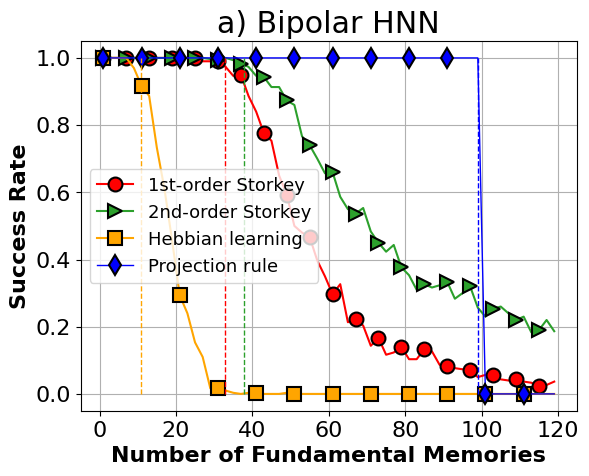

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
@load "JLDs/StorageCapacity_Real.jld2"
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)
plot(Pv,Success[1,:]/Nsim,linewidth=1.5,color="red",linestyle ="solid", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(Pv,Success[2,:]/Nsim,color="#2ca02c",linestyle ="solid", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(Pv,Success[3,:]/Nsim,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

plot(Pv,Success[4,:]/Nsim,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

ps1 = N/sqrt(2*log(N))
plot([ps1, ps1],[0.0, 1.0],color="red",linestyle="dashed",linewidth=1)

ps2 = N/((4*log(N))^(1/3))
plot([ps2, ps2],[0.0, 1.0],color="#2ca02c",linestyle="dashed",linewidth=1)

psC = N/(2*log(N))
plot([psC, psC],[0.0, 1.0],color="orange",linestyle="dashed",linewidth=1)

psP = N-1
plot([psP, psP],[0.0, 1.0],color="blue",linestyle="dashed",linewidth=1)

legend()
grid()

xlabel("Number of Fundamental Memories")
ylabel("Success Rate")
title("a) Bipolar HNN")

savefig("Figures/StorageCapacity_Real.eps",bbox_inches="tight")
savefig("Figures/StorageCapacity_Real.pdf",bbox_inches="tight")

In [19]:
[maximum(Pv[Success[i,:].>=300*0.99]) for i=1:4]

4-element Array{Int64,1}:
 31
 35
  7
 99

In [16]:
[psC, ps1, ps2]

3-element Array{Float64,1}:
 10.857362047581296
 32.95051144911304
 37.864431566545385